In [1]:
import pandas as pd
import numpy as np
import math as math
import statistics
import time
import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import textwrap
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 1000)  
pd.set_option('display.width', 150)
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

# Glossary.csv SOURCED FROM:
https://www.nba.com/stats/help/glossary

In [2]:
glossaryDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Glossary.csv')
glossaryDict = {}
for i in range(len(glossaryDF)):
    stringInRow = glossaryDF.iloc[i].values[0]
    if stringInRow == 'Name':
        feature = glossaryDF.iloc[i-1].values[0]
        feature = feature.upper()
        glossaryDict[feature] = {}
        glossaryDict[feature]['Name'] = {}
        glossaryDict[feature]['Name'] = glossaryDF.iloc[i+1].values[0]
        glossaryDict[feature]['Definition'] = {}
        glossaryDict[feature]['Definition'] = glossaryDF.iloc[i+3].values[0]
        glossaryDict[feature]['Type'] = {}
        glossaryDict[feature]['Type'] = glossaryDF.iloc[i+5].values[0]
        glossaryDict[feature]['Contexts'] = {}

In [3]:
def convertDateColumn(df):
    locationToInsert = df.columns.get_loc('DATE')+1
    dates = pd.to_datetime(df['DATE'],format="%m/%d/%y").dt.date
    df = df.drop(columns='DATE')
    df.insert(locationToInsert,'DATE',dates)
    df = df.sort_values(by=['DATE','GAMEID']).reset_index(drop=True)
    return df
def featureEngineering(df):
    featuresToAddDict = {'OPPT':[],'PTSA':[],'2FGA':[],'2FGM':[],'2FG%':[],
                             'RESULT':[],'PTSDELTA':[],'H/A':[]}
    for i in range(len(df)):
        featuresToAddDict['OPPT'].append(df.iloc[i]['MATCH'][-3:])
        if i % 2 == 0: featuresToAddDict['PTSA'].append(df.iloc[i+1]['PTS'])
        else: featuresToAddDict['PTSA'].append(df.iloc[i-1]['PTS'])
        if df['W/L'][i] == 'L': featuresToAddDict['RESULT'].append(0)
        else: featuresToAddDict['RESULT'].append(1)
        featuresToAddDict['H/A'].append(df['MATCH'][i].count('vs'))
    df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict['OPPT'])
    df.insert(df.columns.get_loc('PTS')+1,'PTSA',featuresToAddDict['PTSA'])
    df.insert(df.columns.get_loc('FG%')+1,'2FGM',df['FGM'] - df['3PM'])
    df.insert(df.columns.get_loc('FG%')+1,'2FGA',df['FGA'] - df['3PA']) 
    df.insert(df.columns.get_loc('FG%')+1,'2FG%',df['2FGM']/df['2FGA'])
    df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict['RESULT'])
    df = df.drop(columns=['W/L'])
    df.insert(df.columns.get_loc('PTSA')+1,'PTSDELTA',df['PTS']-df['PTSA'])
    df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict['H/A'])
    return df

# Traditional.csv

In [4]:
traditionalDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Traditional.csv')
traditionalDF = convertDateColumn(traditionalDF)
traditionalDF = featureEngineering(traditionalDF)

In [43]:
len(traditionalDF[traditionalDF['TEAM'] == 'ATL'])

82

In [5]:
teamCorrelationResults = {}
for team in NBATeams:
    teamCorrelationResults[team] = {}
    for feature in ['2FGA','3PA']:
        teamCorrelationResults[team][feature] = {}
        teamCorrelationResults[team][feature]['TEAM'] = team
        teamCorrelationResults[team][feature]['FEATURE'] = feature
        teamCorrelationResults[team][feature]['R'] = float
        teamCorrelationResults[team][feature]['P'] = float

In [6]:
for team in NBATeams:
    teamDF = traditionalDF[traditionalDF['TEAM'] == team].reset_index(drop=True)
    for feature in ['2FGA','3PA']:
        df = pd.concat([pd.DataFrame(teamDF[feature]),
                            pd.DataFrame(teamDF['PTS'])],axis=1)
        R,P = pearsonr(df[feature],df['PTS'])
        teamCorrelationResults[team][feature]['R'] = R
        teamCorrelationResults[team][feature]['P'] = P

In [7]:
leagueCorrelationResultsDF = pd.DataFrame()
for team in NBATeams:
    teamDF = pd.DataFrame(teamCorrelationResults[team]).T
    teamDF = teamDF.reset_index(drop=True).sort_values(by='R',ascending=False)
    leagueCorrelationResultsDF = pd.concat([leagueCorrelationResultsDF,teamDF],axis=0)
leagueCorrelationResultsDF = leagueCorrelationResultsDF.reset_index(drop=True)
leagueCorrelationResultsDF = leagueCorrelationResultsDF.sort_values(by='R',ascending=False)
leagueCorrelationResultsDF

,TEAM,FEATURE,R,P
0,ATL,2FGA,0.400141,0.000196
18,GSW,3PA,0.354963,0.001067
36,NOP,3PA,0.352841,0.001149
32,MIL,2FGA,0.309459,0.004669
42,ORL,2FGA,0.297276,0.006683
50,SAC,2FGA,0.296377,0.006858
12,DAL,3PA,0.295867,0.00696
48,POR,2FGA,0.283119,0.009956
8,CHI,2FGA,0.280059,0.010824
38,NYK,2FGA,0.262109,0.017369


In [8]:
def regressionEquation(x,y):
    num = (len(x)*np.sum(x*y)) - (sum(x)*sum(y))
    den = (len(x)*np.sum(x**2))-(np.sum(x)**2)
    slope = num/den
    y_intercept = (np.sum(y) - slope*np.sum(x)) / len(x)
    return 'y = '+str(round(slope,4))+'x + '+str(round(y_intercept,4))
def getFeatureDefintionWrapped(feature):
    definition = feature+': '+glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return textwrap.fill(definition,35)

In [9]:
leagueCorrelationResultsDF.head()

,TEAM,FEATURE,R,P
0,ATL,2FGA,0.400141,0.000196
18,GSW,3PA,0.354963,0.001067
36,NOP,3PA,0.352841,0.001149
32,MIL,2FGA,0.309459,0.004669
42,ORL,2FGA,0.297276,0.006683


In [10]:
def plot2AND3pointShotsAttemptedToPointsCorrelation(team,traditionalDF,leagueCorrelationResultsDF):
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
    ax0,ax1 = axes.flatten()
    feature = '2FGA'
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = pd.concat([pd.DataFrame(teamDF[feature]),pd.DataFrame(teamDF['PTS'])],axis=1)
    teamDF = teamDF.sort_values(by=feature)
    R = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == '2FGA')]['R'].values[0]
    P = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == '2FGA')]['P'].values[0]
    R2 = R**2
    polyfit = np.polyfit(teamDF[feature],teamDF['PTS'],1)
    polynomial = np.poly1d(polyfit)
    bestFitLine = regressionEquation(teamDF[feature],teamDF['PTS'])
    label = bestFitLine
    defintion = getFeatureDefintionWrapped(feature)
    ax0.set_xlabel(feature,size=20,fontweight='bold');
    ax0.set_ylabel(team+' POINTS SCORED',size=30,fontweight='bold');
    ax0.set_xlabel(defintion,loc='left',size=25)

    ax0.set_title('R:'+f'{R:.5f}'+' R2:'+f'{R2:.5f}'+' P:'+f'{P:.5f}',size=25,fontweight ='bold');
    ax0.tick_params(labelsize=25)
    ax0.scatter(teamDF[feature],teamDF['PTS'],marker='o',s=75);
    ax0.plot(teamDF[feature].values,polynomial(teamDF[feature].values),linestyle='--',linewidth=3,label=label)
    ax0.grid(True,linewidth=.5)
    ax0.legend(loc="upper left",prop={'size':25})
    
    feature = '3PA'
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = pd.concat([pd.DataFrame(teamDF[feature]),pd.DataFrame(teamDF['PTS'])],axis=1)
    teamDF = teamDF.sort_values(by=feature)
    
    polyfit = np.polyfit(teamDF[feature],teamDF['PTS'],1)
    polynomial = np.poly1d(polyfit)
    ax1.set_xlabel(feature,size=20,fontweight='bold');
    ax1.set_ylabel(team+' POINTS SCORED',size=30,fontweight='bold');
    defintion = getFeatureDefintionWrapped(feature)
    R = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == '3PA')]['R'].values[0]
    p = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == '3PA')]['P'].values[0]
    ax1.set_xlabel(defintion,loc='left',size=25)
    bestFitLine = regressionEquation(teamDF[feature],teamDF['PTS'])
    label = bestFitLine
    ax1.set_title('R:'+f'{R:.5f}'+' R2:'+f'{R2:.5f}'+' P:'+f'{P:.5f}',size=25,fontweight ='bold');
    ax1.tick_params(labelsize=25)
    ax1.scatter(teamDF[feature],teamDF['PTS'],marker='o',s=75);
    ax1.plot(teamDF[feature].values,polynomial(teamDF['3PA'].values),linestyle='--',linewidth=3,label=label);
    ax1.grid(True,linewidth=.5)
    ax1.legend(loc="upper left",prop={'size':25})
    
    plt.show()

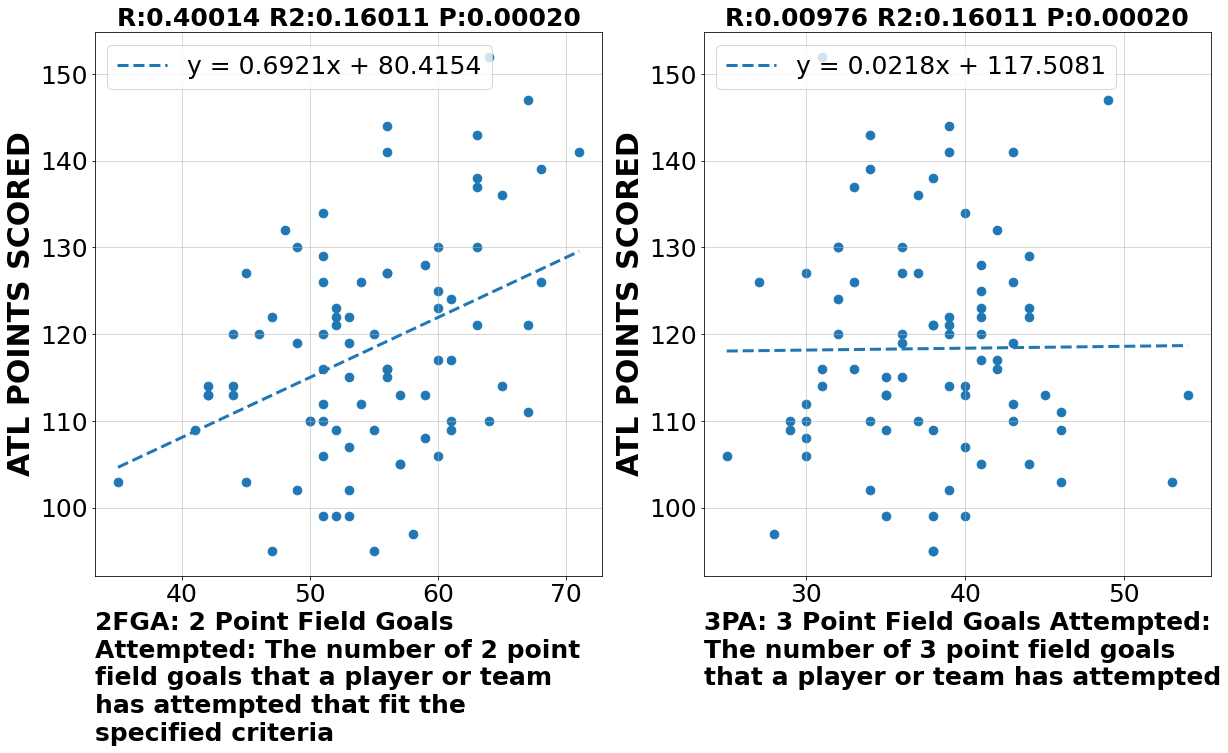

In [11]:
plot2AND3pointShotsAttemptedToPointsCorrelation('ATL',traditionalDF,leagueCorrelationResultsDF)

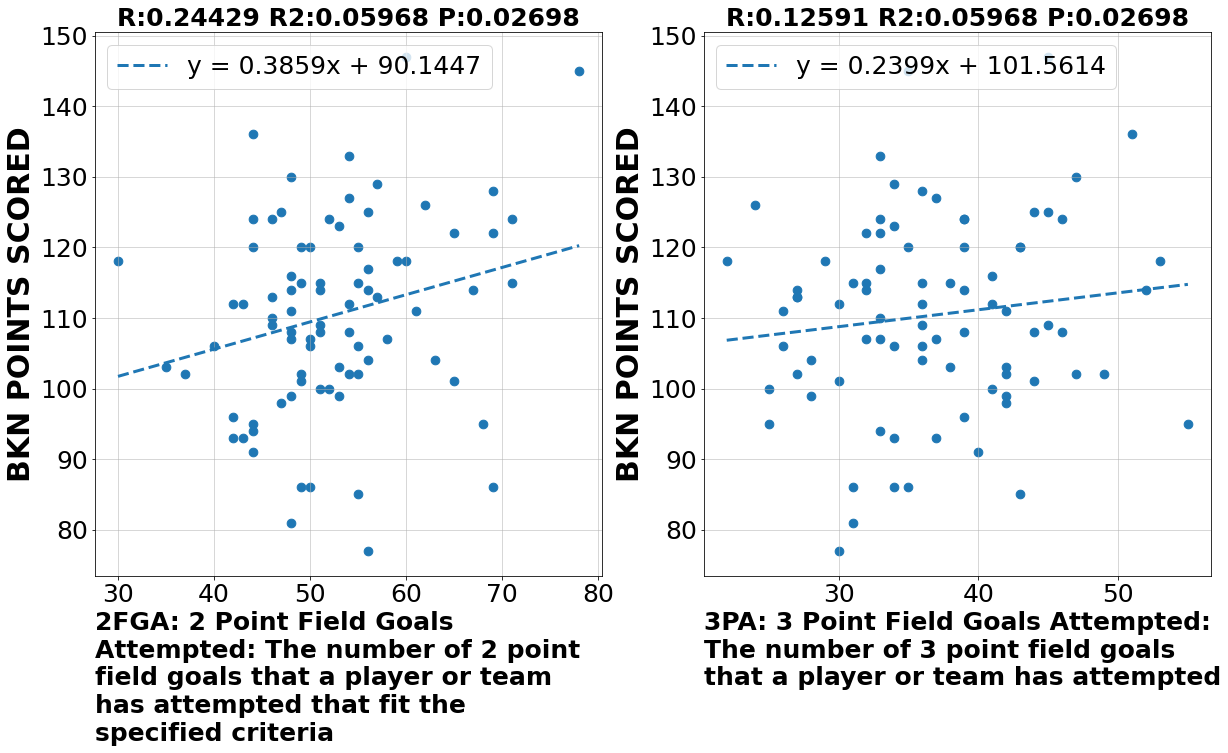

In [12]:
plot2AND3pointShotsAttemptedToPointsCorrelation('BKN',traditionalDF,leagueCorrelationResultsDF)

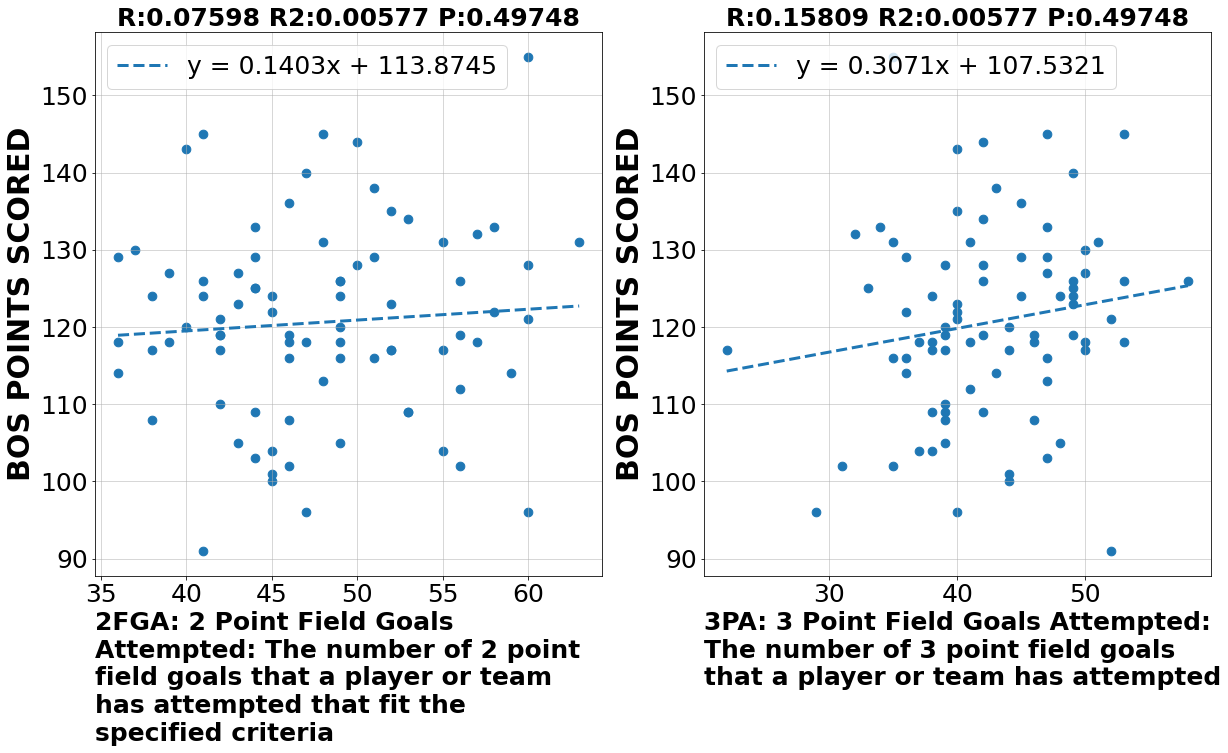

In [13]:
plot2AND3pointShotsAttemptedToPointsCorrelation('BOS',traditionalDF,leagueCorrelationResultsDF)

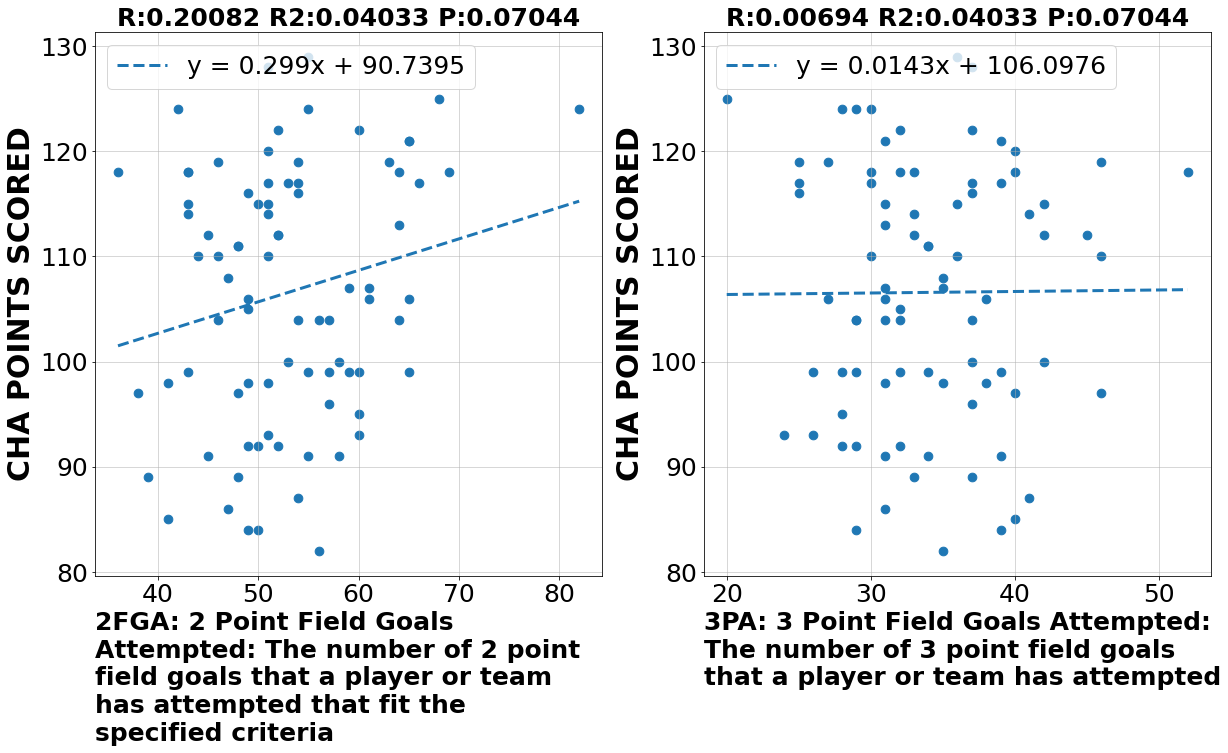

In [14]:
plot2AND3pointShotsAttemptedToPointsCorrelation('CHA',traditionalDF,leagueCorrelationResultsDF)

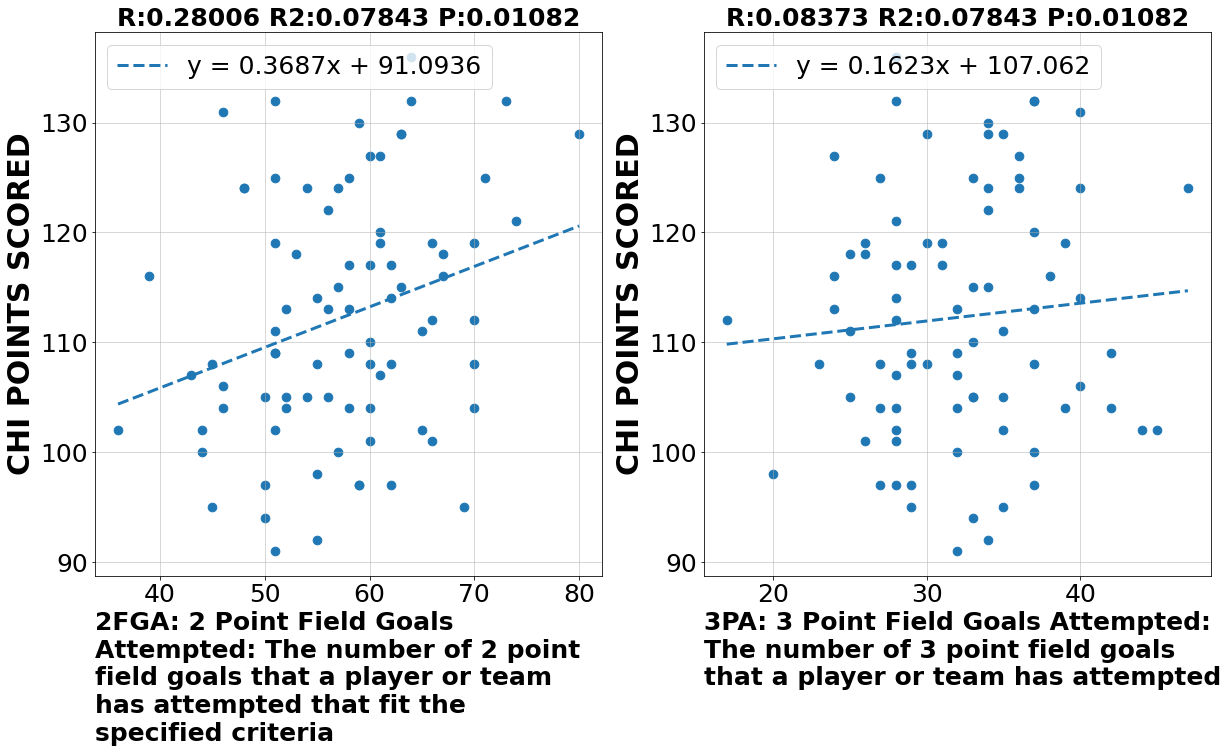

In [15]:
plot2AND3pointShotsAttemptedToPointsCorrelation('CHI',traditionalDF,leagueCorrelationResultsDF)

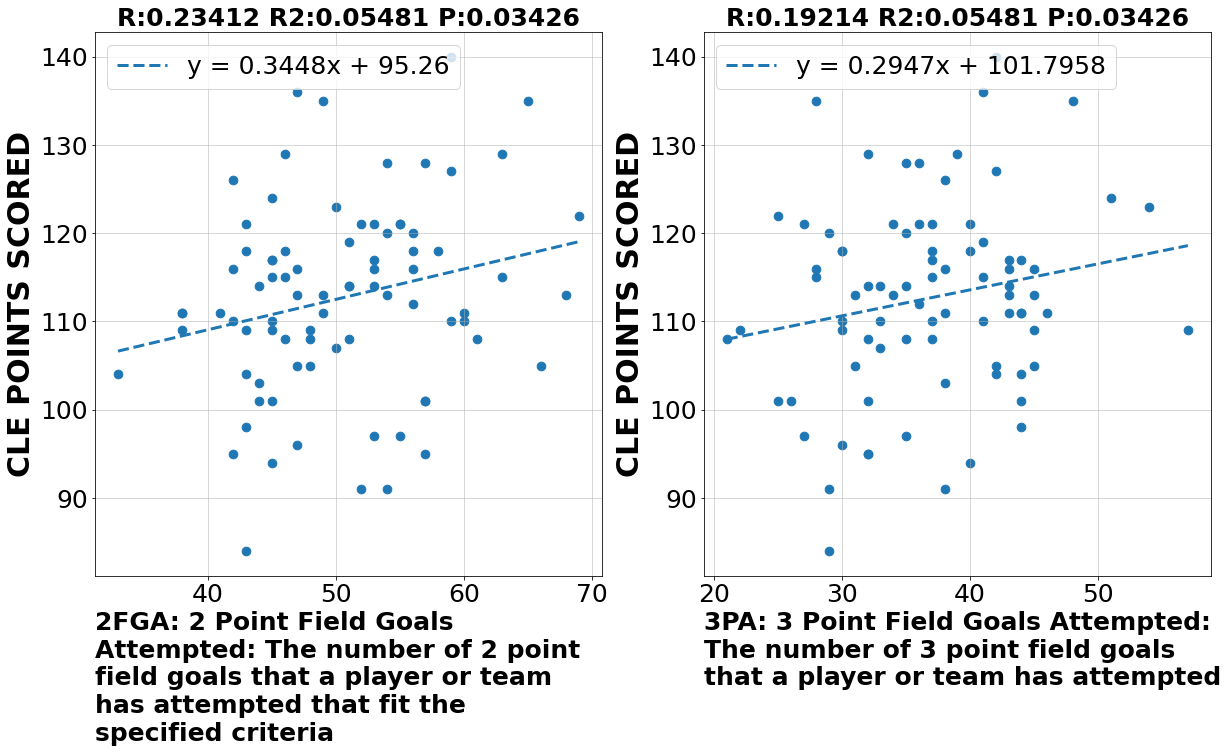

In [16]:
plot2AND3pointShotsAttemptedToPointsCorrelation('CLE',traditionalDF,leagueCorrelationResultsDF)

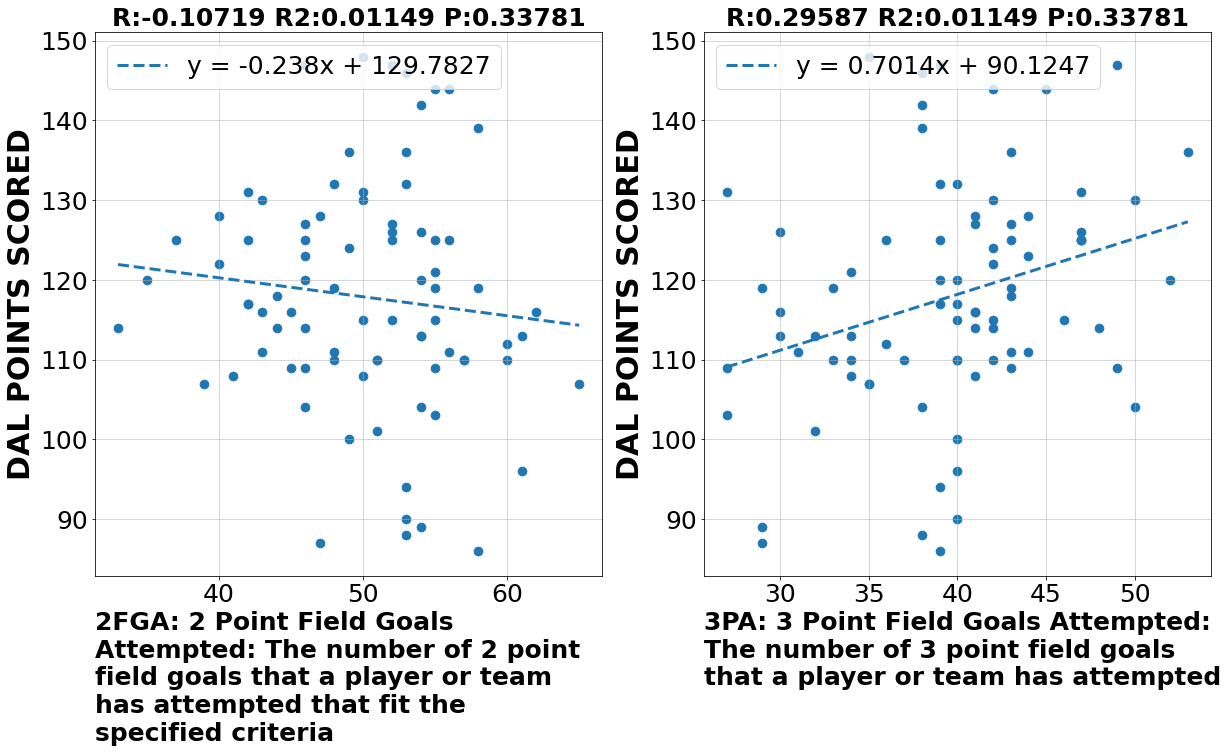

In [17]:
plot2AND3pointShotsAttemptedToPointsCorrelation('DAL',traditionalDF,leagueCorrelationResultsDF)

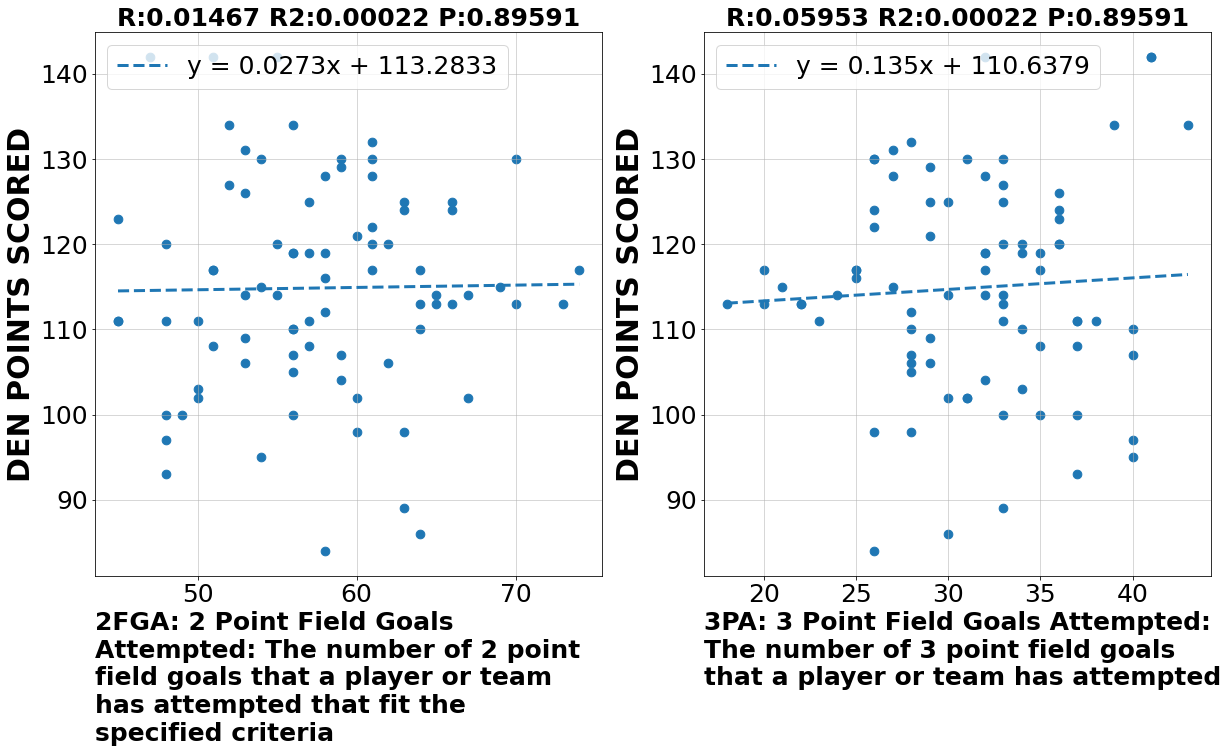

In [18]:
plot2AND3pointShotsAttemptedToPointsCorrelation('DEN',traditionalDF,leagueCorrelationResultsDF)

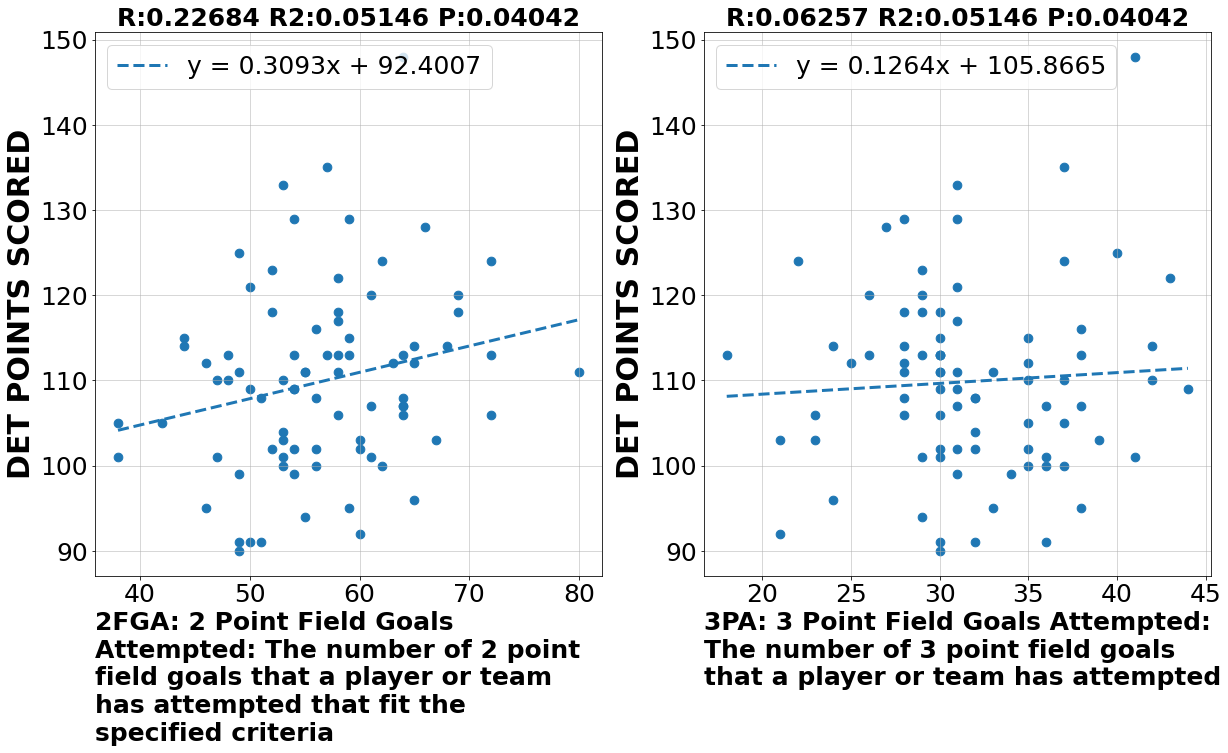

In [19]:
plot2AND3pointShotsAttemptedToPointsCorrelation('DET',traditionalDF,leagueCorrelationResultsDF)

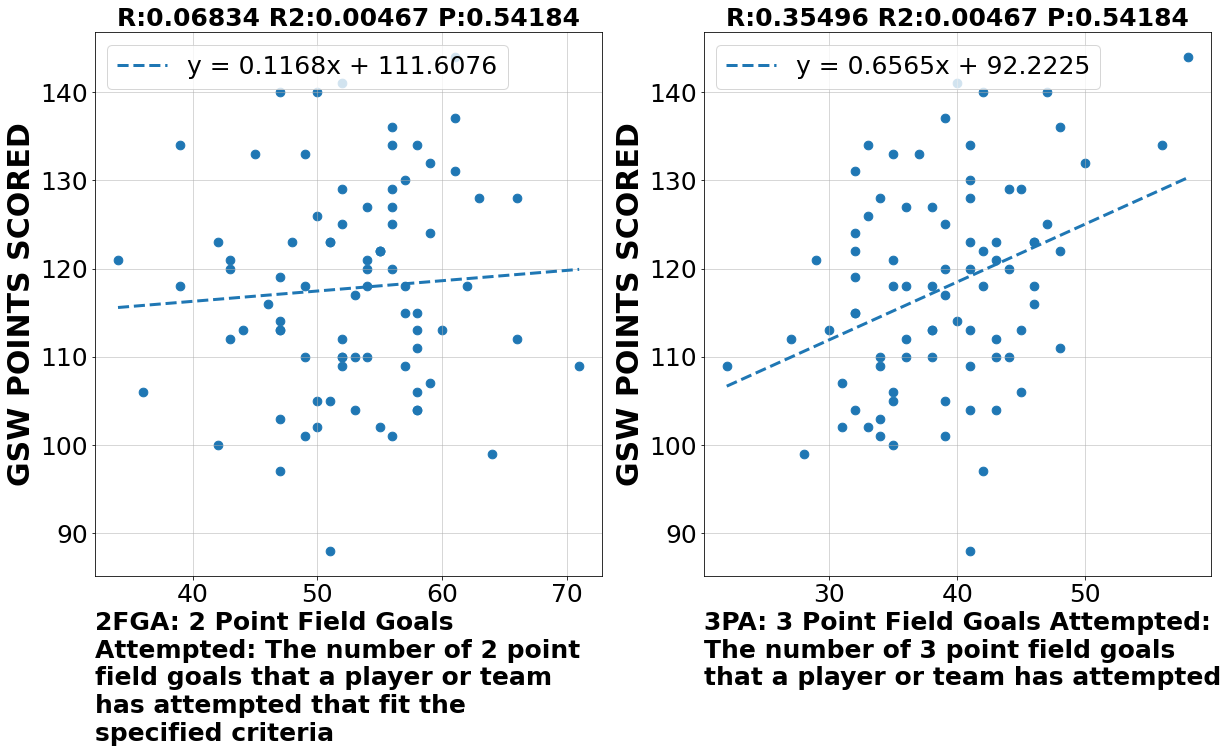

In [20]:
plot2AND3pointShotsAttemptedToPointsCorrelation('GSW',traditionalDF,leagueCorrelationResultsDF)

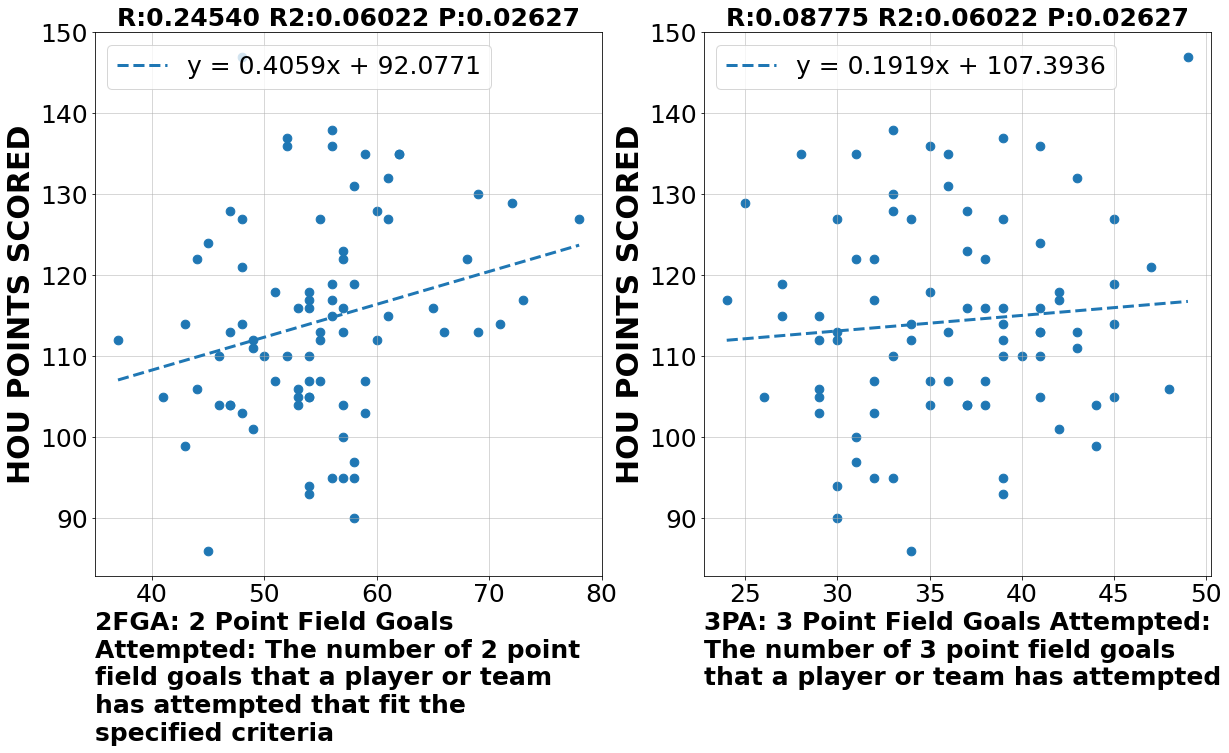

In [21]:
plot2AND3pointShotsAttemptedToPointsCorrelation('HOU',traditionalDF,leagueCorrelationResultsDF)

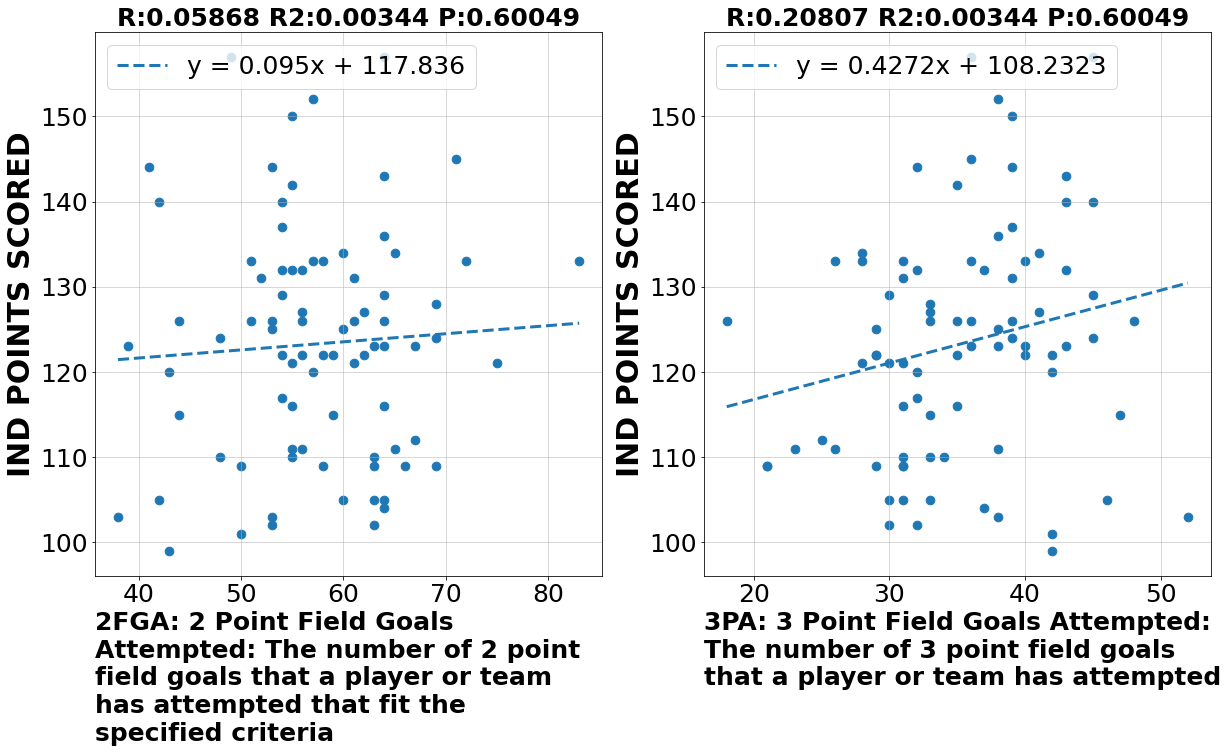

In [22]:
plot2AND3pointShotsAttemptedToPointsCorrelation('IND',traditionalDF,leagueCorrelationResultsDF)

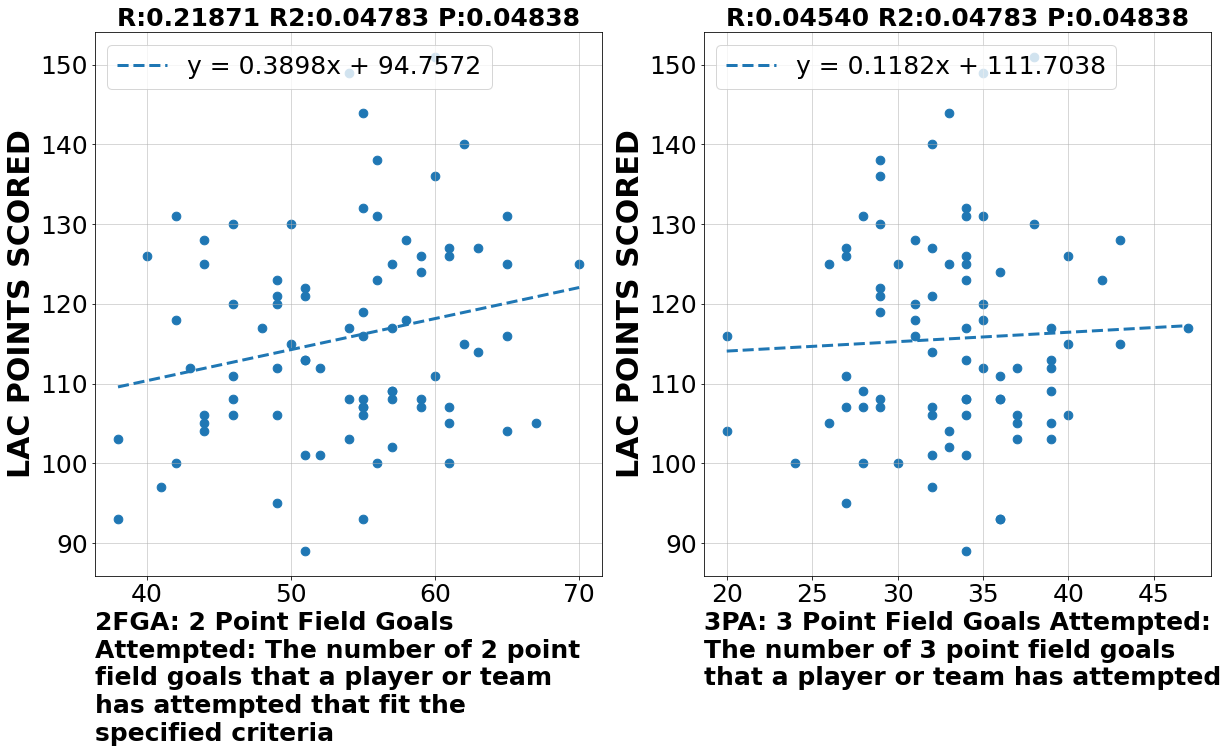

In [23]:
plot2AND3pointShotsAttemptedToPointsCorrelation('LAC',traditionalDF,leagueCorrelationResultsDF)

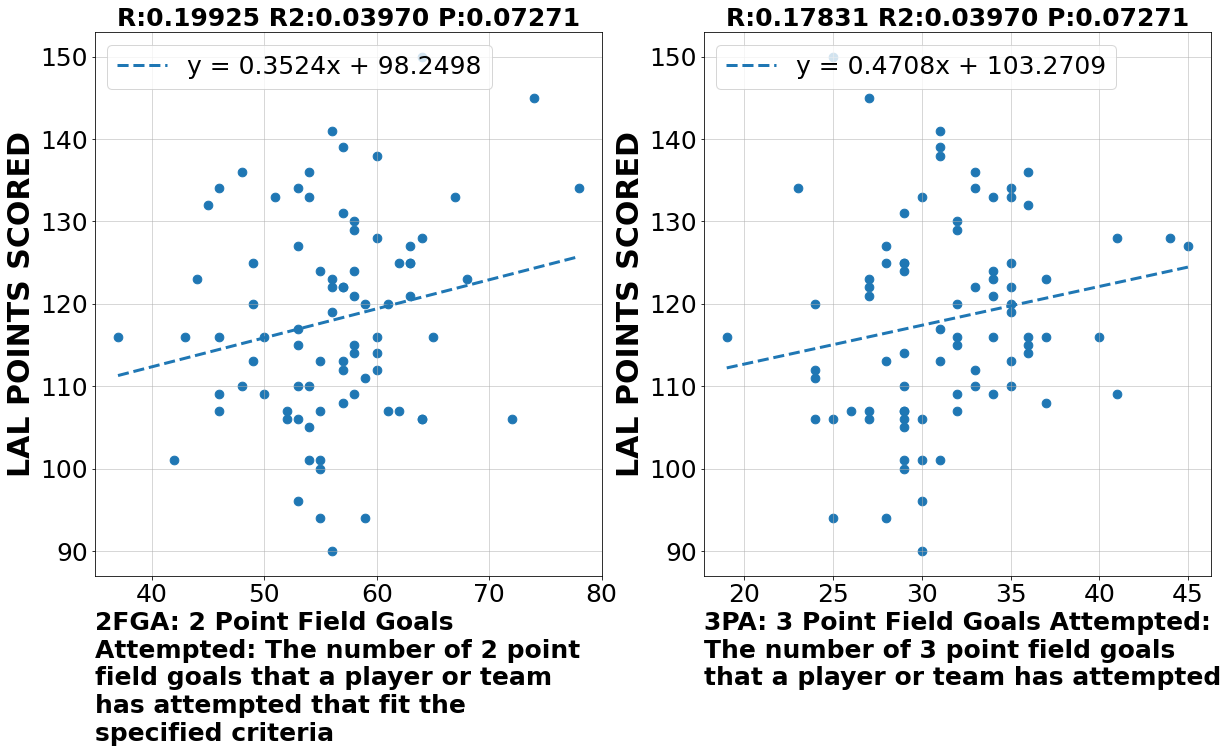

In [24]:
plot2AND3pointShotsAttemptedToPointsCorrelation('LAL',traditionalDF,leagueCorrelationResultsDF)

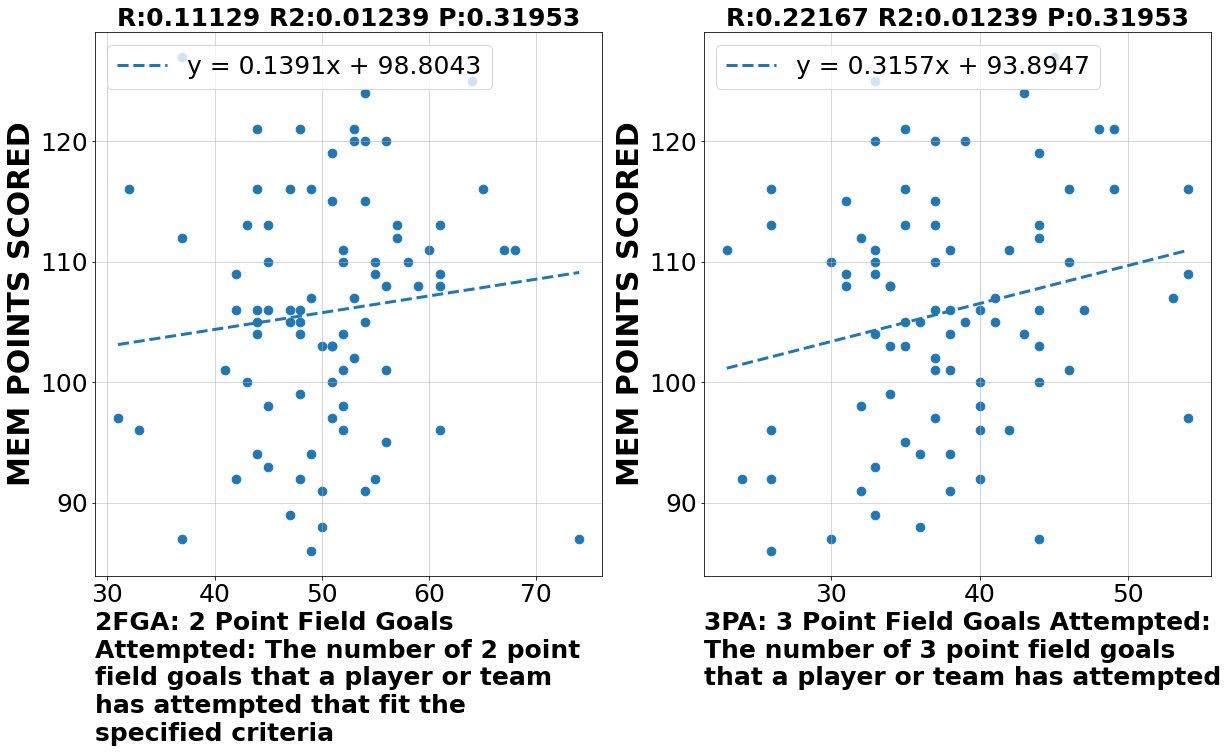

In [25]:
plot2AND3pointShotsAttemptedToPointsCorrelation('MEM',traditionalDF,leagueCorrelationResultsDF)

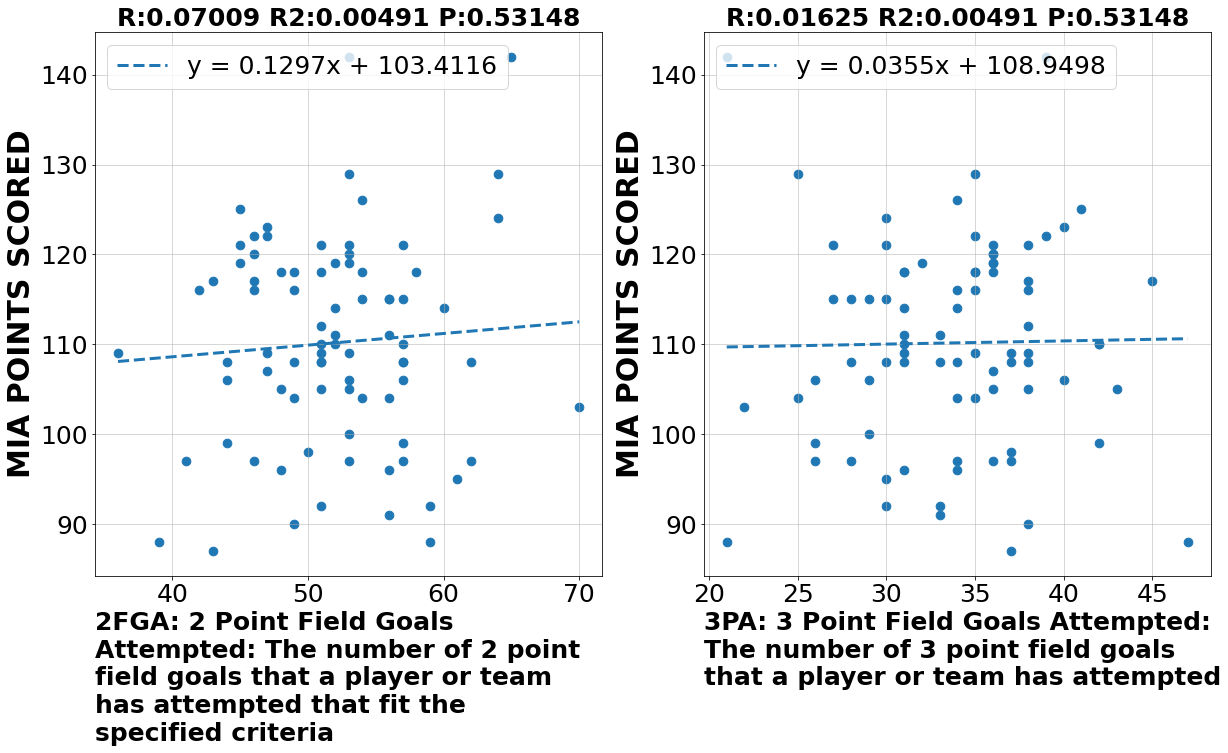

In [26]:
plot2AND3pointShotsAttemptedToPointsCorrelation('MIA',traditionalDF,leagueCorrelationResultsDF)

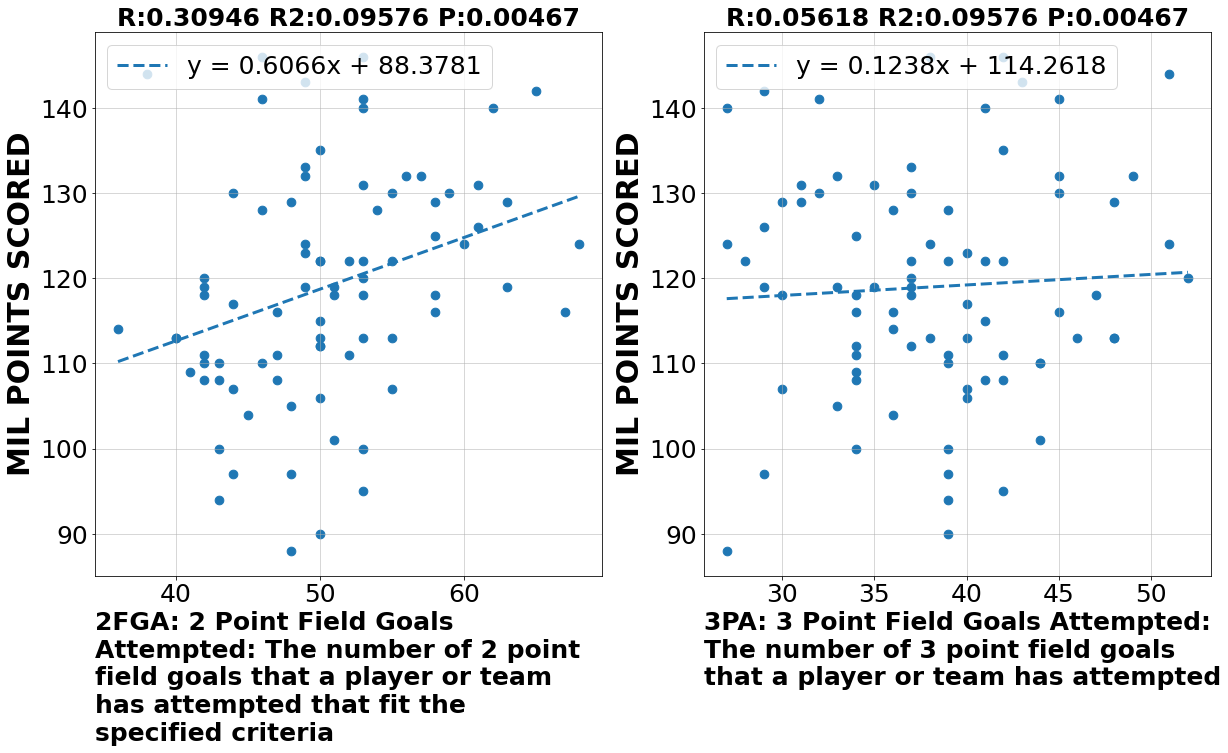

In [27]:
plot2AND3pointShotsAttemptedToPointsCorrelation('MIL',traditionalDF,leagueCorrelationResultsDF)

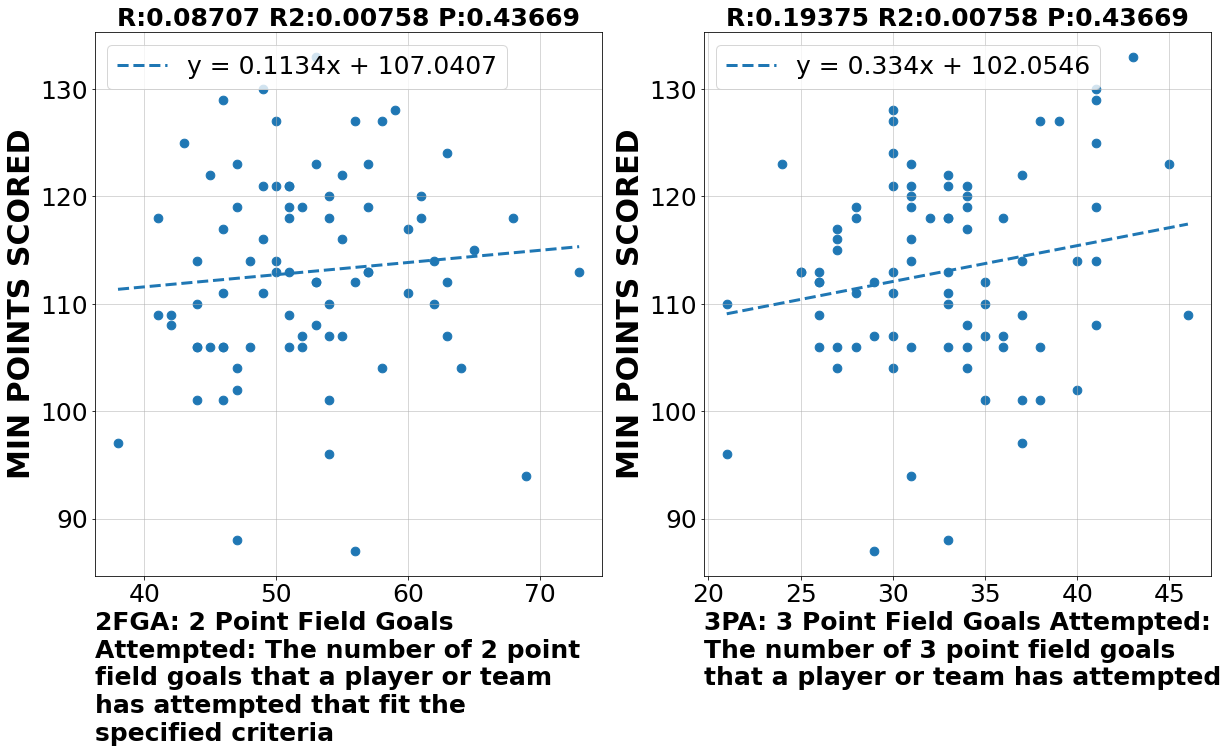

In [28]:
plot2AND3pointShotsAttemptedToPointsCorrelation('MIN',traditionalDF,leagueCorrelationResultsDF)

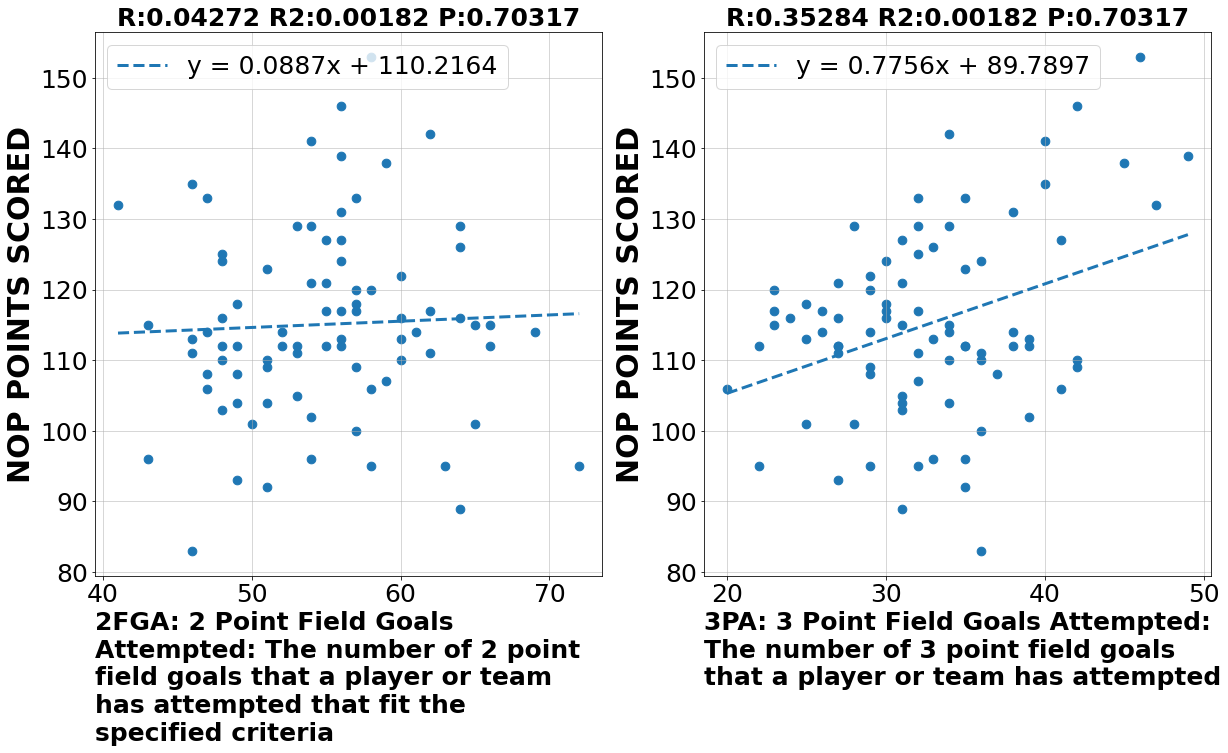

In [29]:
plot2AND3pointShotsAttemptedToPointsCorrelation('NOP',traditionalDF,leagueCorrelationResultsDF)

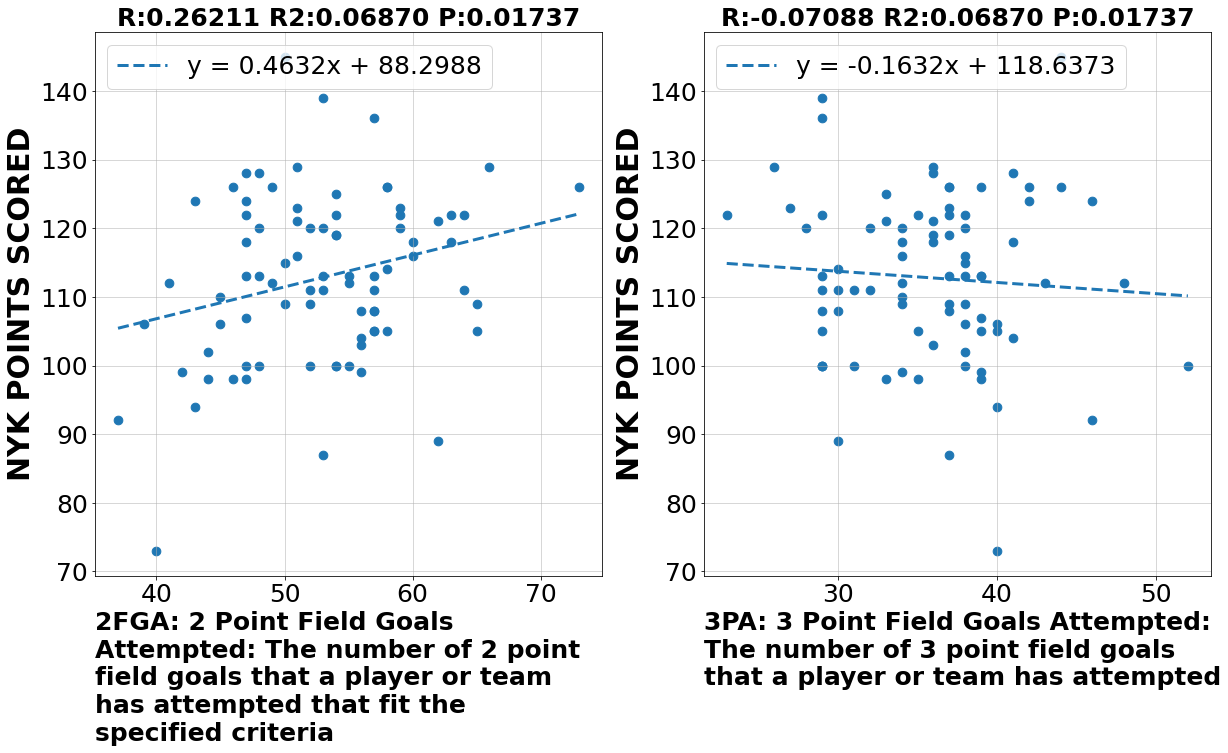

In [30]:
plot2AND3pointShotsAttemptedToPointsCorrelation('NYK',traditionalDF,leagueCorrelationResultsDF)

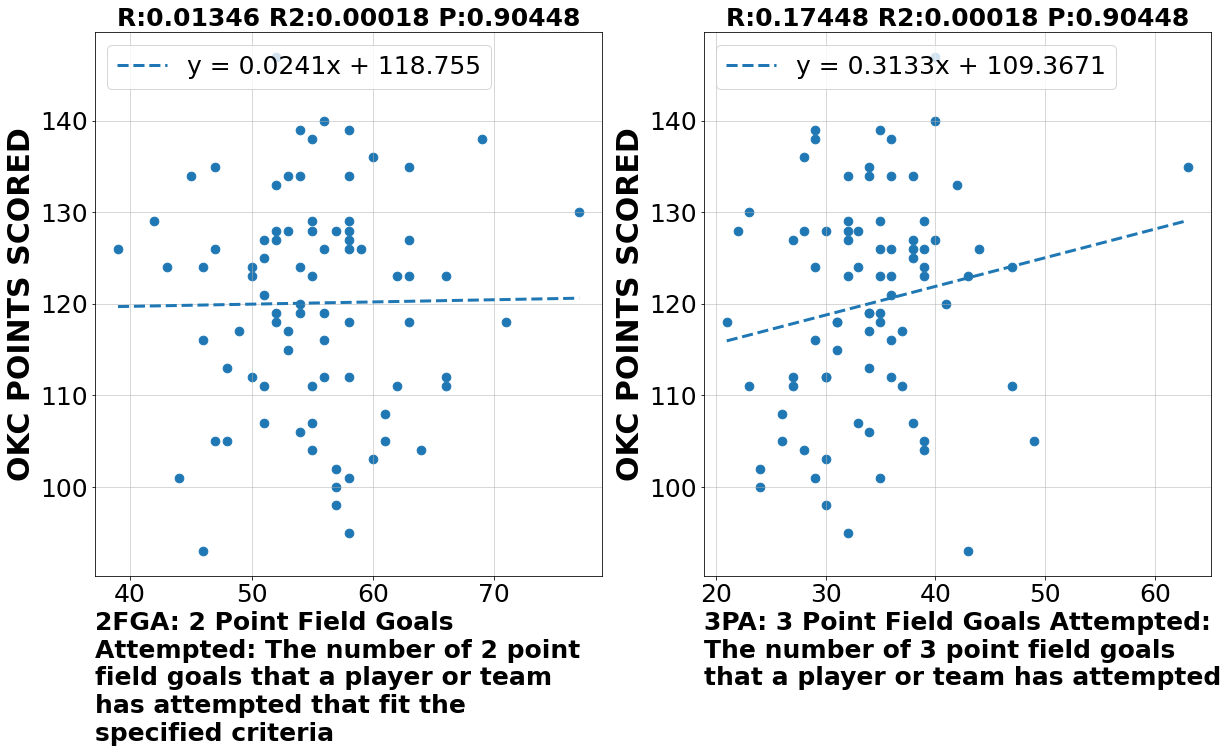

In [31]:
plot2AND3pointShotsAttemptedToPointsCorrelation('OKC',traditionalDF,leagueCorrelationResultsDF)

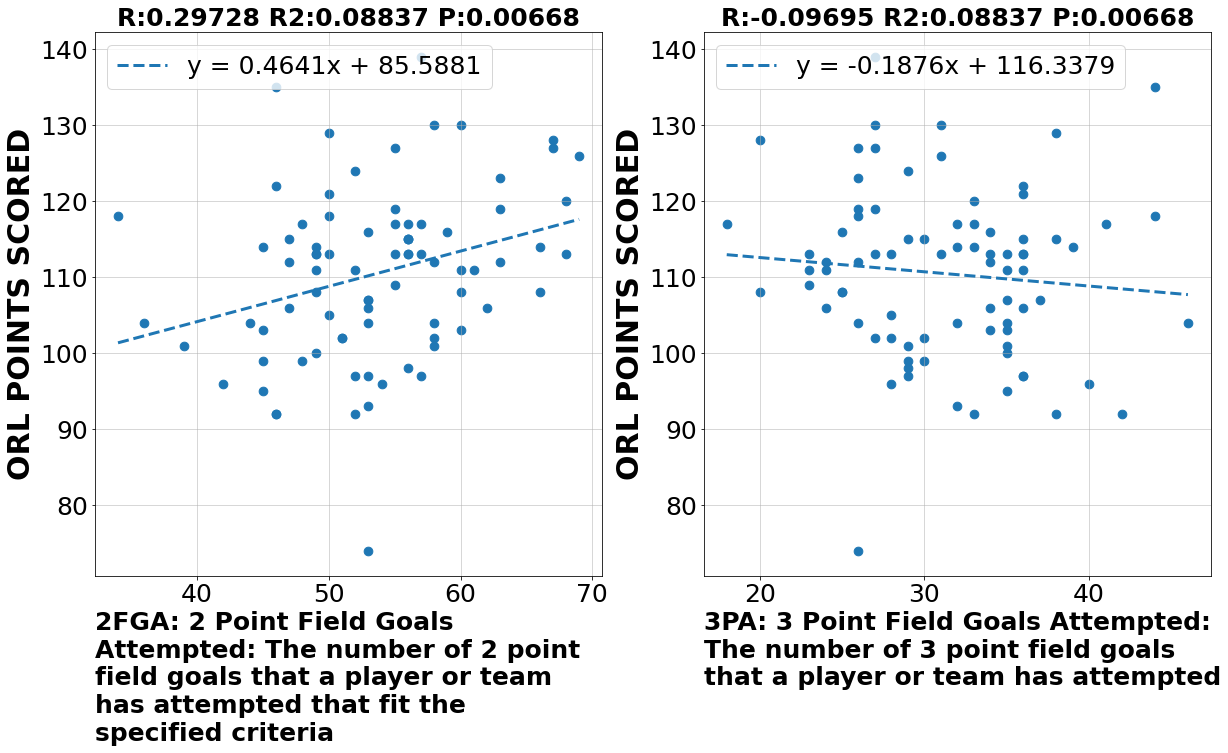

In [32]:
plot2AND3pointShotsAttemptedToPointsCorrelation('ORL',traditionalDF,leagueCorrelationResultsDF)

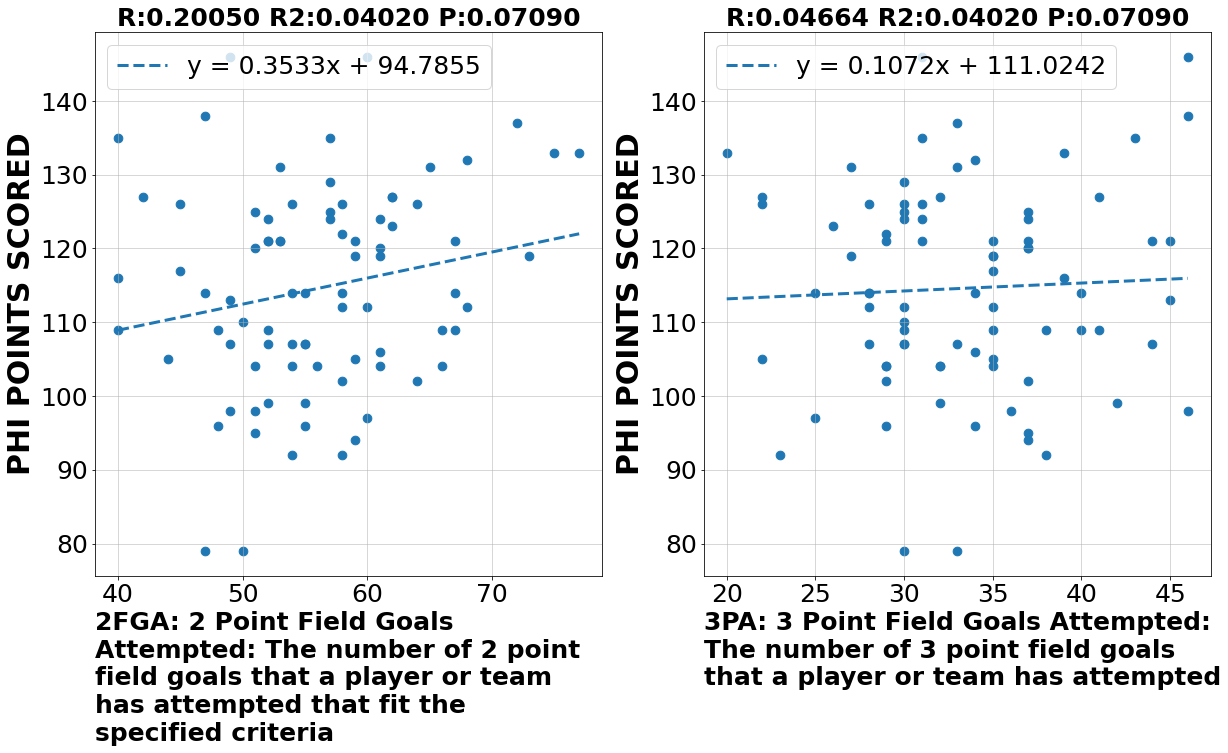

In [33]:
plot2AND3pointShotsAttemptedToPointsCorrelation('PHI',traditionalDF,leagueCorrelationResultsDF)

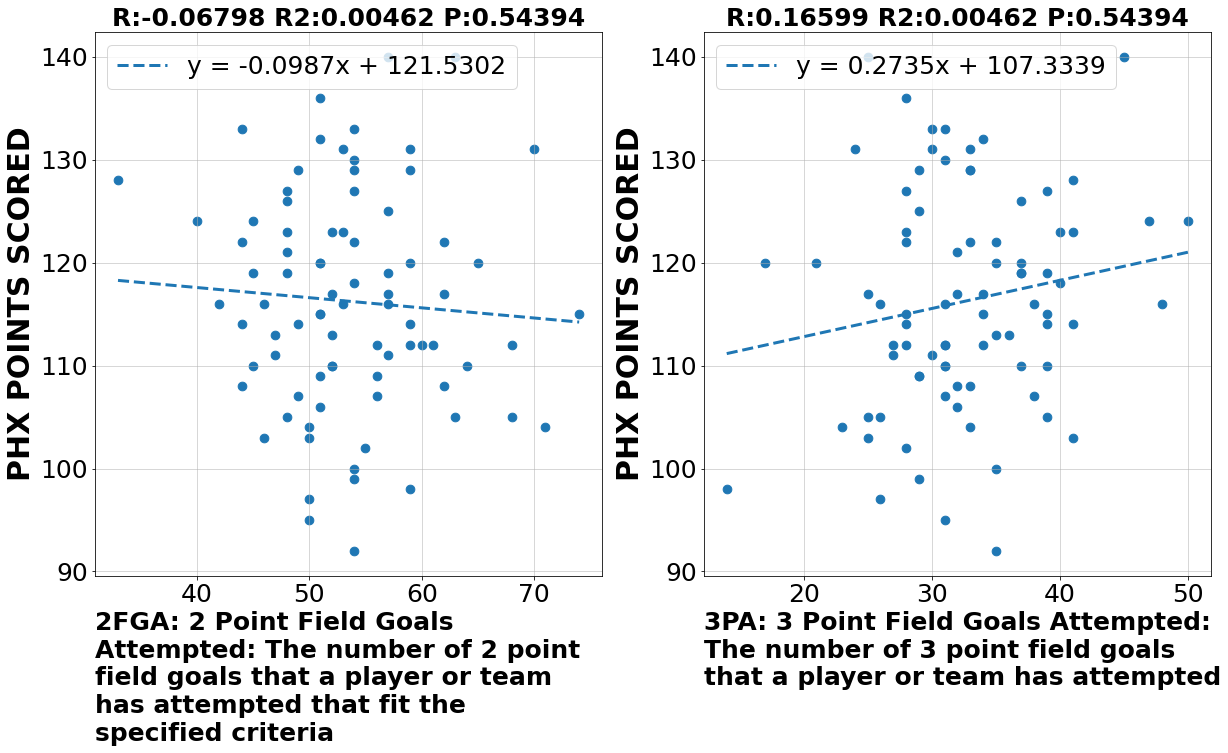

In [34]:
plot2AND3pointShotsAttemptedToPointsCorrelation('PHX',traditionalDF,leagueCorrelationResultsDF)

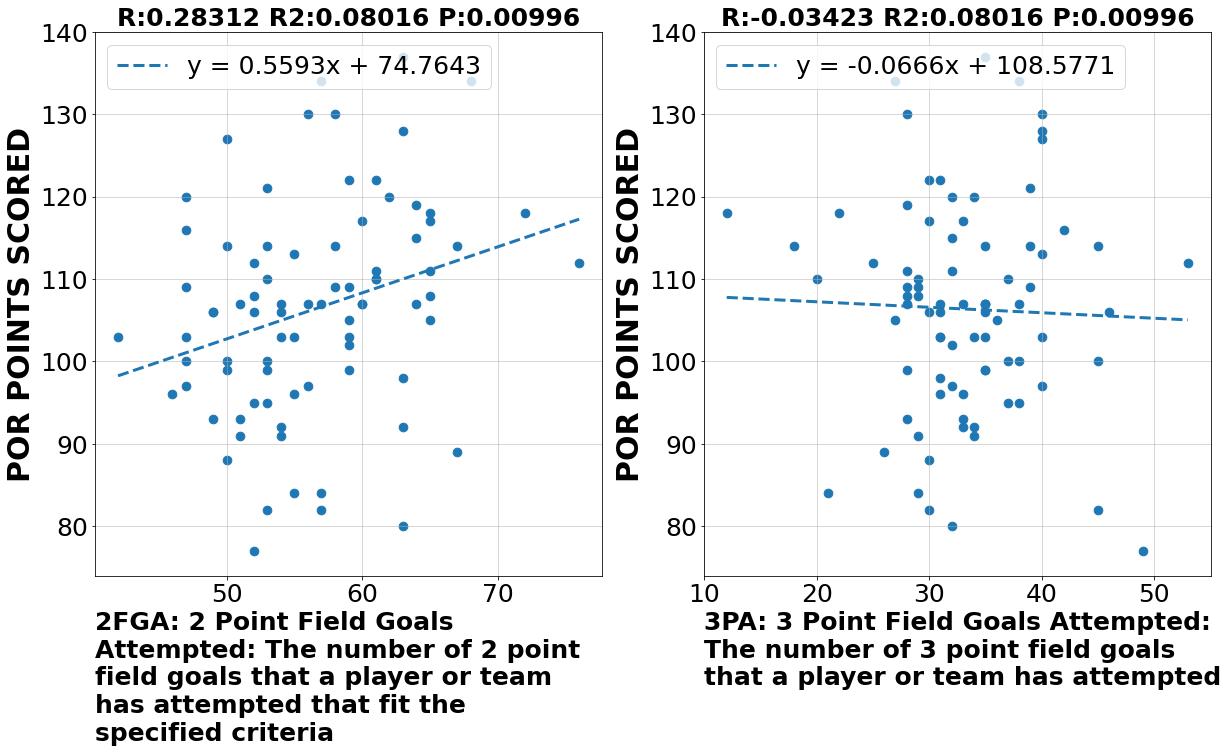

In [35]:
plot2AND3pointShotsAttemptedToPointsCorrelation('POR',traditionalDF,leagueCorrelationResultsDF)

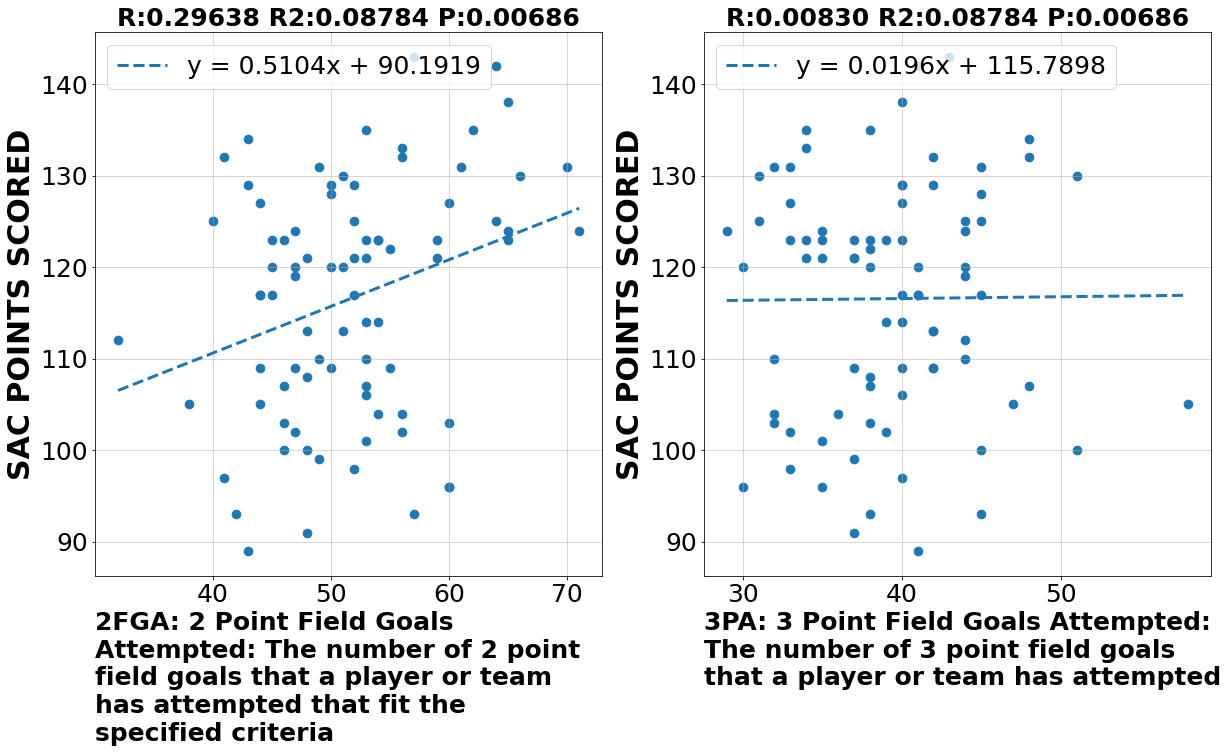

In [36]:
plot2AND3pointShotsAttemptedToPointsCorrelation('SAC',traditionalDF,leagueCorrelationResultsDF)

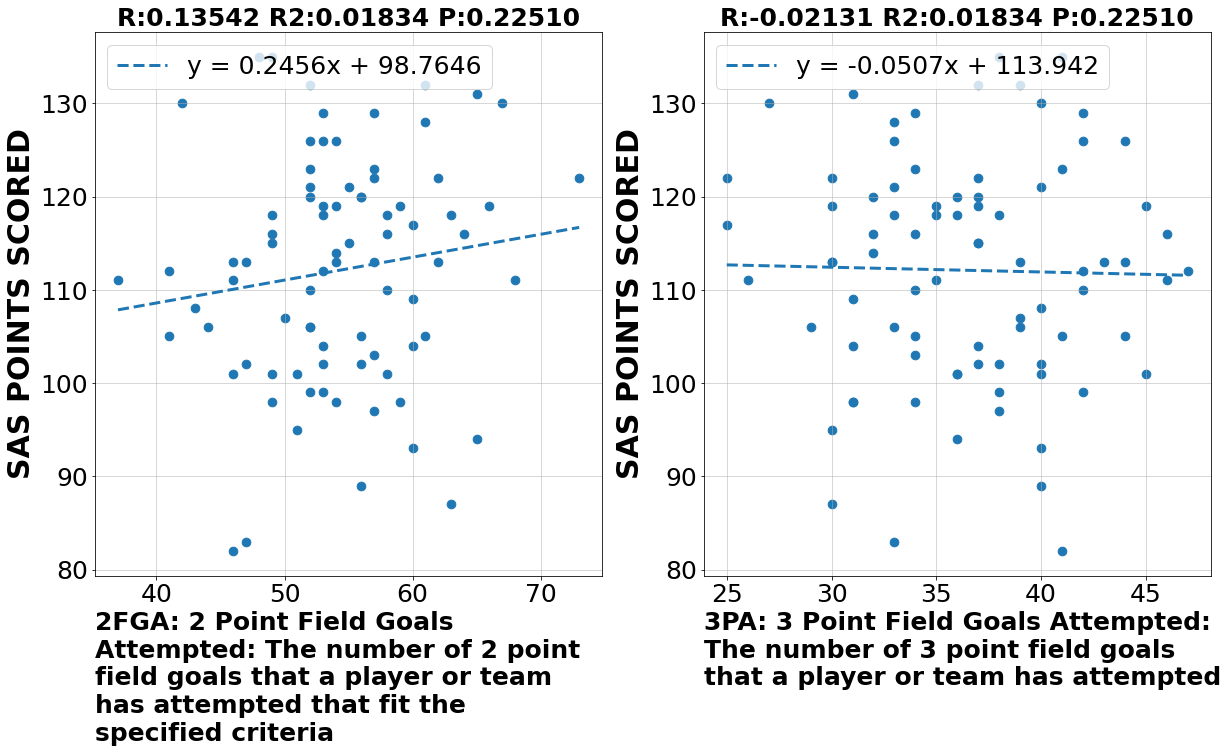

In [37]:
plot2AND3pointShotsAttemptedToPointsCorrelation('SAS',traditionalDF,leagueCorrelationResultsDF)

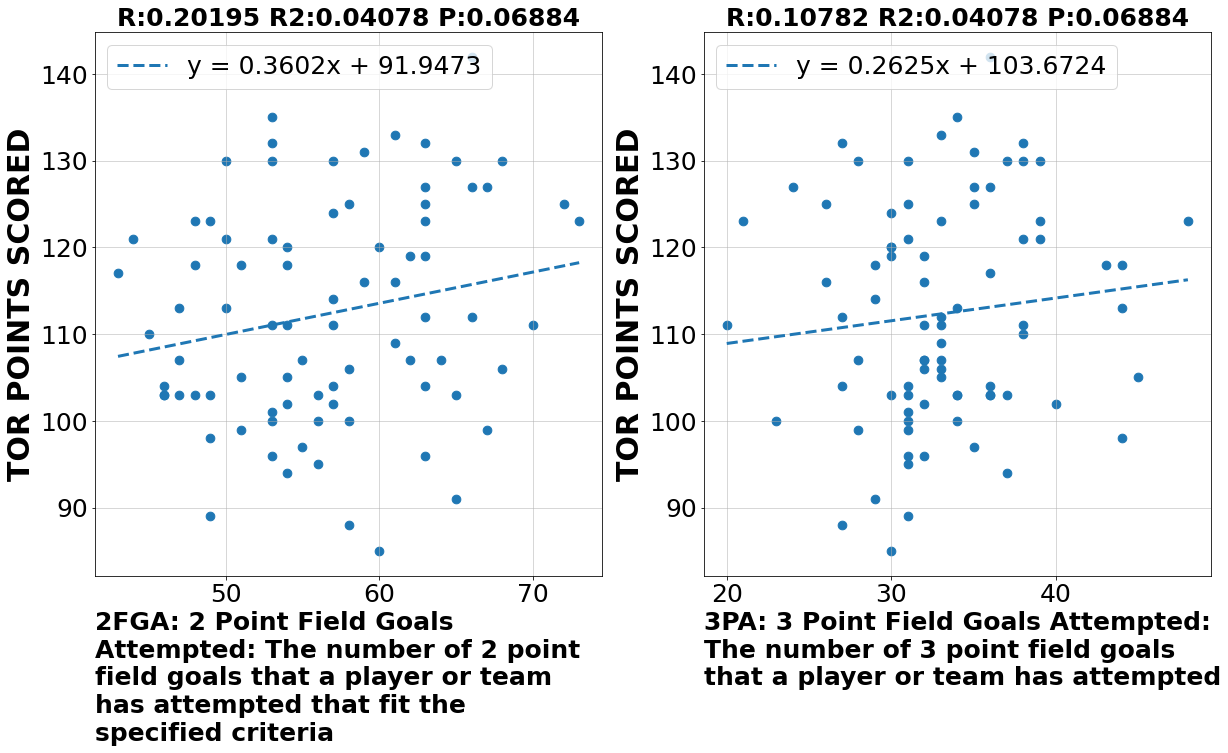

In [38]:
plot2AND3pointShotsAttemptedToPointsCorrelation('TOR',traditionalDF,leagueCorrelationResultsDF)

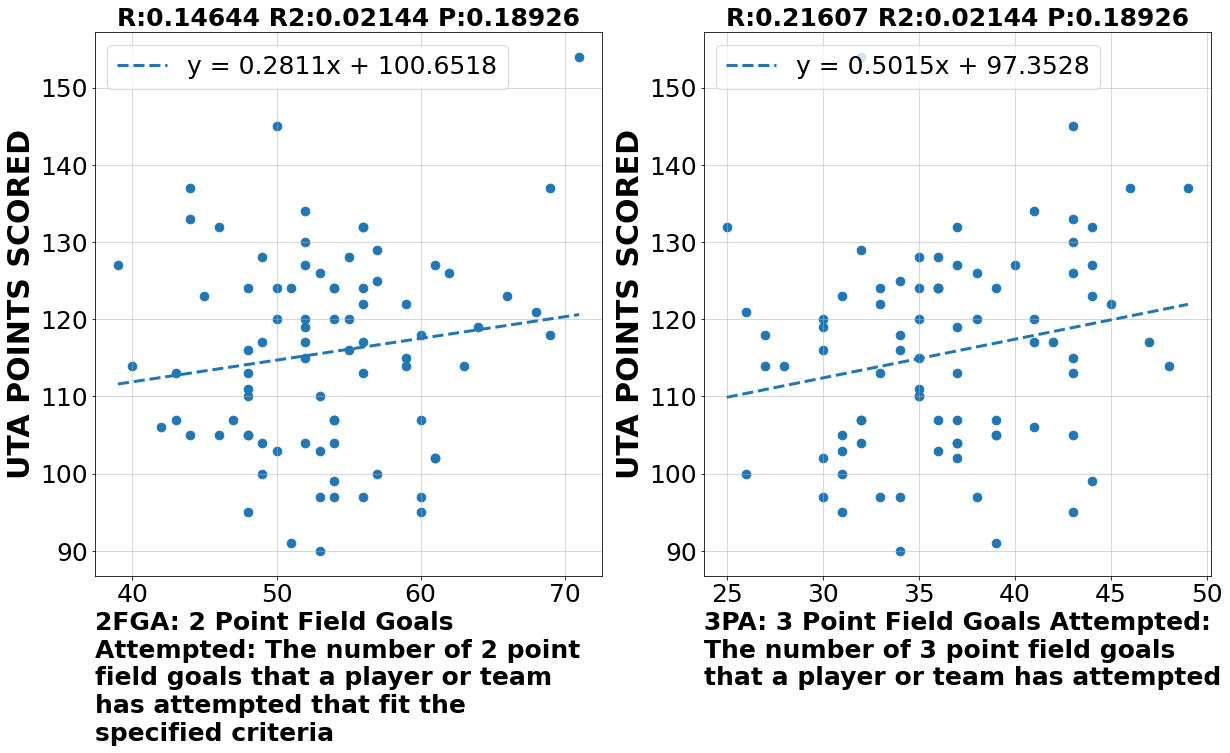

In [39]:
plot2AND3pointShotsAttemptedToPointsCorrelation('UTA',traditionalDF,leagueCorrelationResultsDF)

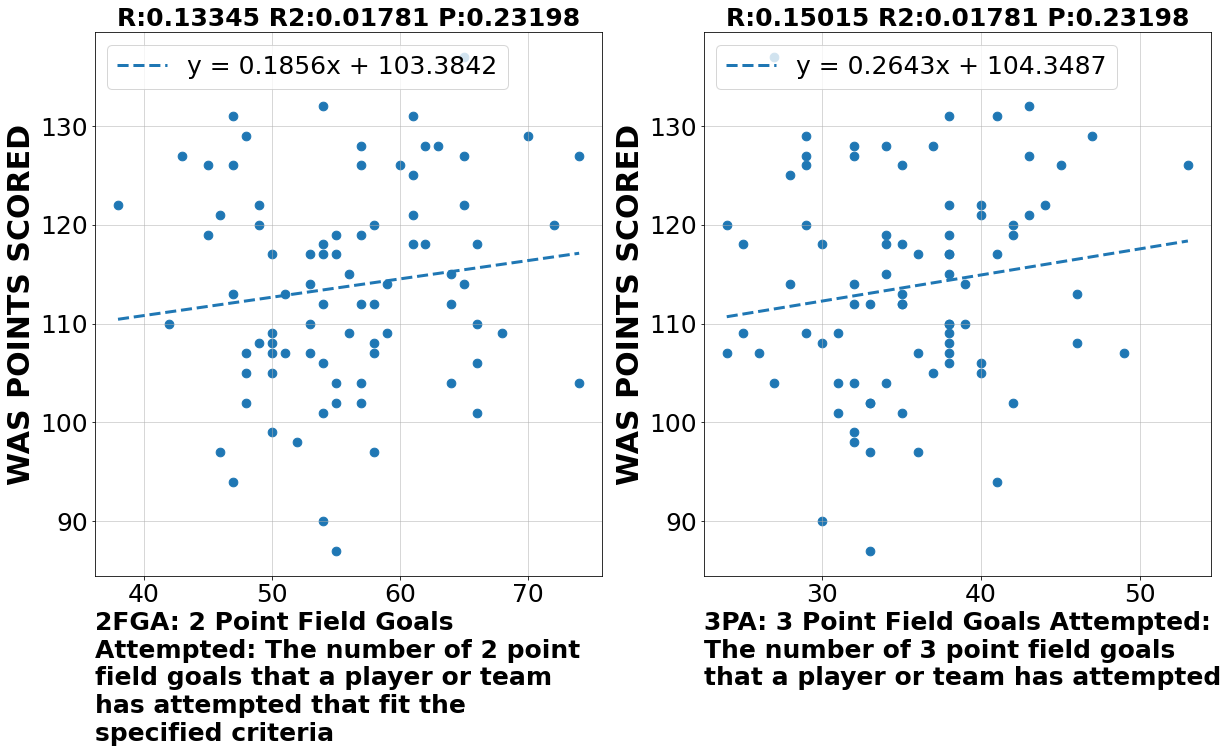

In [40]:
plot2AND3pointShotsAttemptedToPointsCorrelation('WAS',traditionalDF,leagueCorrelationResultsDF)